# Intro Task, Object Localization 

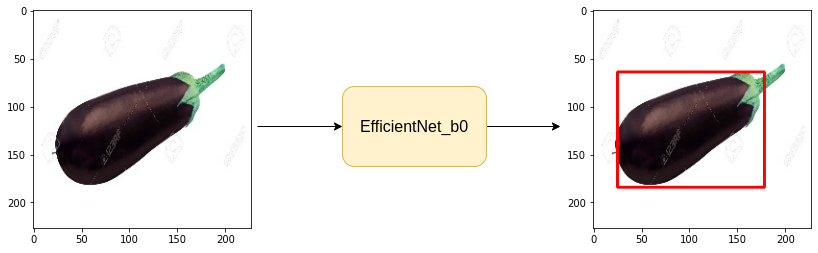

In [1]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to c:\users\hemak\appdata\local\temp\pip-req-build-ft0bg9jy


  ERROR: Error [WinError 2] The system cannot find the file specified while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: C:\Users\hemak\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

'git' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE = "/content/object-localization-dataset/train.csv"
DATA_DIR = "/content/object-localization-dataset/"

DEVICE = "cuda"

BATCH_SIZE =16
IMG_SIZE =140

LR = 0.001
EPOCHS =40
MODEL_NAME = "efficientnet_b0"

NUM_COR =4

In [ ]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

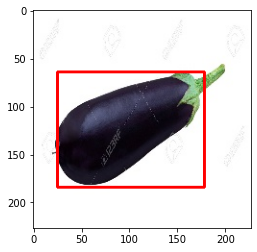

In [ ]:
row = df.iloc[100]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2,(255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [ ]:
train_df, valid_df = train_test_split(df,test_size= 0.20, random_state=42)

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs=A.Compose([
                      A.Resize(IMG_SIZE, IMG_SIZE),
                      A.HorizontalFlip(p=0.5),
                      A.VerticalFlip(p = 0.5),
                      A.Rotate()
],bbox_params=A.BboxParams(format = "pascal_voc", label_fields=["class_labels"]))
valid_augs=A.Compose([
                      A.Resize(IMG_SIZE, IMG_SIZE),
                               ],bbox_params=A.BboxParams(format = "pascal_voc", label_fields=["class_labels"]))




# Create Custom Dataset

In [ ]:
from albumentations import augmentations
class ObjLocDataset(torch.utils.data.Dataset):
    def __init__(self,df,augmentations=None):
      self.df =df
      self.augmentations = augmentations

    def __len__(self):
      return len(self.df)
    def __getitem__(self, idx):
      row = self.df.iloc[idx]
      xmin = row.xmin
      ymin = row.ymin
      xmax = row.xmax
      ymax = row.ymax

      bbox = [[xmin, ymin, xmax, ymax]]
      img_path = DATA_DIR + row.img_path
      img = cv2.imread(img_path)
      img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      if self.augmentations:
        data = self.augmentations(image = img, bboxes=bbox, class_labels=[None])
        img = data["image"]
        bbox = data["bboxes"][0]

      img = torch.from_numpy(img).permute(2,0,1)/255.0 #(h,w,c) ->(c,h,w)
      bbox = torch.Tensor(bbox)
      return img, bbox

In [ ]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [ ]:
print(f"Total Examples in The Trainset : {len(trainset)}")
print(f"Total Examples in The validset : {len(validset)}")

Total Examples in The Trainset : 148
Total Examples in The validset : 38


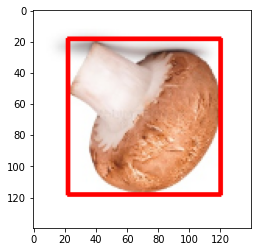

In [ ]:
img, bbox = trainset[33]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader = torch.utils.data.DataLoader(validset,batch_size=BATCH_SIZE,shuffle=False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images, bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn 
import timm

In [ ]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel, self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)
  def forward(self,images,gt_bboxes =None):
    bboxes =self.backbone(images)
    if gt_bboxes !=None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes,loss
    return bboxes

In [ ]:
model = ObjLocModel()
model.to(DEVICE);

In [ ]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model,dataloader,optimizer):
  total_loss = 0.0
  model.train() #Dropout ON
  for data in tqdm(dataloader):
    images,gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE),gt_bboxes.to(DEVICE)
    bboxes,loss=model(images,gt_bboxes)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()
  return total_loss / len(dataloader)

In [ ]:
def eval_fn(model,dataloader):
  total_loss = 0.0
  model.eval() #Dropout OFF
  with torch.no_grad():
    for data in tqdm(dataloader):
      images,gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE),gt_bboxes.to(DEVICE)
      bboxes,loss=model(images,gt_bboxes)
      total_loss+=loss.item()
    return total_loss / len(dataloader)

#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(model,trainloader,optimizer)
  valid_loss = eval_fn(model,validloader)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),"best_model.pt")
    print("WEIGHTS.ARE.SAVED")
    best_valid_loss = valid_loss
  print(f"Epoch : {i + 1} train loss : {train_loss} valid loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS.ARE.SAVED
Epoch : 1 train loss : 5381.5060546875 valid loss : 6261.576985677083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS.ARE.SAVED
Epoch : 2 train loss : 2065.851611328125 valid loss : 1134.9605509440105


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS.ARE.SAVED
Epoch : 3 train loss : 1214.9997680664062 valid loss : 429.9885965983073


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS.ARE.SAVED
Epoch : 4 train loss : 770.1341430664063 valid loss : 219.54634602864584


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS.ARE.SAVED
Epoch : 5 train loss : 613.450927734375 valid loss : 163.7093048095703


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6 train loss : 432.97327575683596 valid loss : 191.10465240478516


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS.ARE.SAVED
Epoch : 7 train loss : 314.3380523681641 valid loss : 147.3610076904297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 train loss : 262.78747711181643 valid loss : 175.18053181966147


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 train loss : 212.7543701171875 valid loss : 149.77012379964194


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS.ARE.SAVED
Epoch : 10 train loss : 157.01463775634767 valid loss : 128.79770151774088


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS.ARE.SAVED
Epoch : 11 train loss : 143.37238235473632 valid loss : 118.42931111653645


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS.ARE.SAVED
Epoch : 12 train loss : 101.44283523559571 valid loss : 101.33361562093098


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS.ARE.SAVED
Epoch : 13 train loss : 101.3995204925537 valid loss : 97.27515665690105


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14 train loss : 111.06541442871094 valid loss : 124.03465525309245


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS.ARE.SAVED
Epoch : 15 train loss : 111.30347290039063 valid loss : 91.32289377848308


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16 train loss : 80.93299407958985 valid loss : 92.55093892415364


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17 train loss : 73.72126579284668 valid loss : 109.5200703938802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18 train loss : 81.50419273376465 valid loss : 96.1495361328125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS.ARE.SAVED
Epoch : 19 train loss : 69.00769157409668 valid loss : 90.77612813313802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 20 train loss : 83.42665214538575 valid loss : 109.0883076985677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS.ARE.SAVED
Epoch : 21 train loss : 88.57904968261718 valid loss : 82.53263727823894


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22 train loss : 81.43559494018555 valid loss : 99.16111755371094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23 train loss : 97.59916496276855 valid loss : 111.14398193359375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24 train loss : 64.56836738586426 valid loss : 140.3536834716797


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS.ARE.SAVED
Epoch : 25 train loss : 47.82783451080322 valid loss : 79.20629247029622


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26 train loss : 56.58750610351562 valid loss : 81.60814158121745


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS.ARE.SAVED
Epoch : 27 train loss : 49.772583389282225 valid loss : 53.12333552042643


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28 train loss : 47.367648696899415 valid loss : 55.51322809855143


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29 train loss : 41.6389835357666 valid loss : 71.70959599812825


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30 train loss : 54.10711498260498 valid loss : 61.31623331705729


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31 train loss : 43.32222938537598 valid loss : 81.84765625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 train loss : 35.78828582763672 valid loss : 86.34793853759766


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33 train loss : 44.641970252990724 valid loss : 68.59628804524739


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 train loss : 38.89721488952637 valid loss : 54.1501210530599


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35 train loss : 40.60650424957275 valid loss : 63.556251525878906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 train loss : 48.017740631103514 valid loss : 89.89419937133789


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37 train loss : 39.120804977416995 valid loss : 75.98874409993489


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 train loss : 29.456114196777342 valid loss : 81.64933013916016


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39 train loss : 48.12014179229736 valid loss : 105.67369588216145


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40 train loss : 38.323564529418945 valid loss : 90.1208012898763


#Inference

In [ ]:
import utils

In [1]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
with torch.no_grad():
  image, gt_bbox = validset[1] #(c,h,w)
  image = image.unsqueeze(0).to(DEVICE) #(bs,c,h,w)
  out_bbox = model(image)
  utils.compare_plots(image,gt_bbox,out_bbox)

NameError: name 'model' is not defined

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya